# Imports

In [1]:
import numpy as np
from scipy import special
from scipy import stats
import scipy
from scipy.ndimage.filters import gaussian_filter1d
from numpy.linalg import eig
from numpy.linalg import multi_dot

# Manuscript code
from seroprevalence import *

# Figures
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from util import *

# MDI Recommendations

MDI stands for *Model & Demographic Informed*. It is a **variance reduction strategy**. In plain language, its goal is to help allocate more samples to those subpopulations whose accurate measurement will be most beneficial. 

A quick example illustrates this point: suppose that you are trying to estimate the overall prevalence at a college, which consists of students, teachers. Suppose that there are 9 students for every 1 teacher. In this case, it would be wise to allocate more samples to the students because they make up 90% of the population; splitting the tests 50%/50% would be inadvisable. 

### Key questions prior to computing an MDI strategy

1. What is your goal? 
    1. Estimates of prevalence in each subpopulation.
    2. Estimate of overall prevalence.
    3. Parameterization of a model.
2. What data do you have? 
    4. Demographic data (% of total population in each subpopulation). 
    5. A model and next-generation matrix. 
    6. Estimates of existing prevalence across subpopulations.
    
Depending on the answers to these questions, MDI makes different recommendations. If there are multiple goals and therefore multiple recommendations, we recommend simply averaging them. 

# Glossary

\begin{align}
    n & &\text{total number of test kits available}\\
    n_i & &\text{recommended number of tests for subpop } i \\
    \theta_i & &\text{estimate of prevalence in subpop } i \\
    \theta_i^* & & 1 - \text{sp} + \theta_i(\text{se} + \text{sp} +1) \\
    d_i & & \text{fraction of population in subpop } i \\
    NGM & & \text{a model's next-generation matrix}\\
    x_i & & i^{\text{th}}\text{entry of dominant eigenvector of } NGM
\end{align}

# MDI Formulas 
## A. Estimating prevalence in each subpopulation

**MDI (no existing seroprevalence estimates)**:
$$n_i = \frac{n}{\sum_j 1} =\frac{n}{\text{# of subpopulations}}$$

**MDI (existing seroprevalence estimates)**:
$$n_i = n\frac{\sqrt{\theta^*_i(1-\theta^*_i)}}{\sum_j \sqrt{\theta^*_j(1-\theta^*_j)}}$$


## B. Estimating overall prevalence

**MDI (no existing seroprevalence estimates)**:
$$n_i = n\frac{d_i}{\sum_j d_j} =n d_i$$

**MDI (existing seroprevalence estimates)**:
$$n_i = n\frac{d_i \sqrt{\theta^*_i(1-\theta^*_i)}}{\sum_j d_j \sqrt{\theta^*_j(1-\theta^*_j)}}$$

## C. Parameterization of a model

**MDI (no existing seroprevalence estimates)**:
$$n_i = n\frac{x_i}{\sum_j x_j}$$

**MDI (existing seroprevalence estimates)**:
$$n_i = n\frac{x_i \sqrt{\theta^*_i(1-\theta^*_i)}}{\sum_j x_j \sqrt{\theta^*_j(1-\theta^*_j)}}$$

In [21]:
# A quick helper to make pretty plots.
def plot_helper(ni,ax,color):
    # Plot results
    x = np.arange(2.5,80,5)
    ax.bar(x,ni,
          width=3.9,
          facecolor=color)
    ax.set_xlabel('age')
    ax.set_xlim([-1,81])
    ax.set_ylim(bottom=0)
    ax.set_xticks(np.arange(0,85,5))
    # find the values and append to list
    totals=[]
    for i in ax.patches:
        totals.append(i.get_height())
    # set individual bar lables using above list
    total = sum(totals)
    for idx,i in enumerate(ax.patches):
        # get_x pulls left or right; get_height pushes up or down
        ax.text(x[idx], i.get_height()+3.0, \
                str(int(i.get_height())), fontsize=12,
                    color='black',ha='center')
    ax.set_ylabel('target samples, $n_i$')
    finalize(ax,ignoreLegend=True)

# Hypothetical Examples

### 1. Ecuador (goal: estimate overall seroprevalence)
- Goal: overall seroprevalence
- Country: Ecuador
- Preliminary estimates of $\theta_i$: 6\% in those under 40, 5\% in those over 40
- $n=1500$ tests


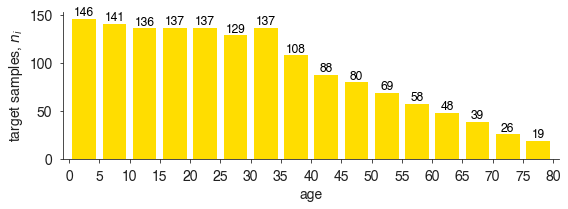

In [19]:
n = 1500
country = 'Ecuador'
age_demographics = get_population_demographics(country) #UN World Population Prospects
theta_i = np.array([6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,])/100
numerator = age_demographics*np.sqrt(theta_i*(1-theta_i))
ni = np.round(n* numerator/np.sum(numerator))

# Plot results
color = np.array([255, 221, 0])/255
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,3))
plot_helper(ni,ax,color)
plt.tight_layout()

### 2. Portugal (goal: parameterize a model of the status quo ante contact patterns)
- Goal: parameterize a model under _status quo ante_ contact patterns
- Country: Portugal
- Preliminary estimates of $\theta_i$: 5\% in those under 40, 3\% in those over 40
- $n=2500$ tests


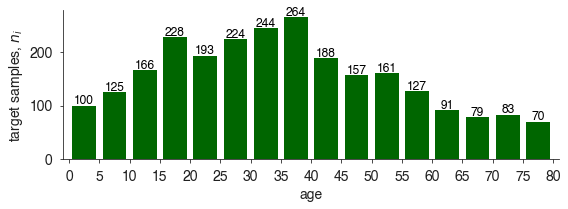

In [20]:
n=2500
theta_i = np.array([5,5,5,5,5,5,5,5,3,3,3,3,3,3,3,3,])/100
# Contact and Demographic Structure (Prem et al, UN WPP)
country = 'Portugal'
contact_data = load_contact_data() # PREM et al
age_demographics = get_population_demographics(country) # UNWPP
C = contact_data[country]['all']  
# Model parameters (Davies et al)
yvec,_ = get_clinical_fraction(1) # DAVIES
uvec = np.ones(16)*0.078          # DAVIES
f = 0.5    # DAVIES
EdS = 7    # DAVIES
EdP = 2.4  # BACKER
EdC = 3.2  # KUCHARSKI
# Next generation matrix
N = NGM(C,uvec,yvec,f,EdS,EdP,EdC)
# Eigenvector
xi = get_evec(N)
# Samples
numerator = xi*np.sqrt(theta_i*(1-theta_i))
ni = np.round(n*numerator/np.sum(numerator))
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,3))
plot_helper(ni,ax,'#006600')
plt.tight_layout()

### 3. Argentina (goal: parameterize a model with social distancing)
- Goal: parameterize a model witha mixture of home, work, school, and other contact patterns
- Country: Argentina
- Preliminary estimates of $\theta_i$: none
- $n=8000$ tests

Here we use: 
- $1.5\ \times$ home contact
- $0\ \times$ school contact
- $0.75\ \times$ work contact
- $0.75\ \times$ other contact

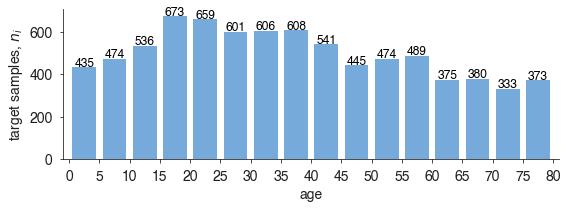

In [23]:
n=8000
# Contact and Demographic Structure (Prem et al, UN WPP)
country = 'Argentina'
contact_data = load_contact_data() # PREM et al
age_demographics = get_population_demographics(country) # UNWPP
home = contact_data[country]['home']
school = contact_data[country]['school']
other = contact_data[country]['other']
work = contact_data[country]['work']
C = 1.5*home + 0*school + 0.75*work + 0.75*other
# Model parameters (Davies et al)
yvec,_ = get_clinical_fraction(1) # DAVIES
uvec = np.ones(16)*0.078          # DAVIES
f = 0.5    # DAVIES
EdS = 7    # DAVIES
EdP = 2.4  # BACKER
EdC = 3.2  # KUCHARSKI
# Next generation matrix
N = NGM(C,uvec,yvec,f,EdS,EdP,EdC)
# Eigenvector
xi = get_evec(N)
# Samples
numerator = xi
ni = np.round(n*numerator/np.sum(numerator))
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,3))
plot_helper(ni,ax,'#75AADB')
plt.tight_layout()